In [3]:
# Adam personal notebook

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE 

In [5]:
df_test = pd.read_csv('Test_set_values.csv')
df_labels = pd.read_csv('Training_set_labels.csv')
df_train = pd.read_csv('Training_set_values.csv')

In [6]:
# Joining df_train and df_labels so we have our target variable. 

df_new_train = df_train.join(df_labels, how='inner', lsuffix='id_left')
df_new_train.drop(columns='idid_left', axis=1, inplace=True)
df_new_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  wa

Missing values: funder, installer, subvillage, public_meeting, scheme_management, scheme_name, permit

Let's find out how many are missing out of our test and training data.

In [7]:
print(df_new_train.isna().sum())
print(df_test.isna().sum())

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [8]:
## Dropping Funder because it shouldn't have any impact on well status.
## Doesn't matter who paid for the well

df_new_train.drop(columns='funder', axis=1, inplace=True)
df_test.drop(columns='funder', axis=1, inplace=True)

In [9]:
# Installer seems to count a bit given if it was a corporation vs. a small group. Might change
# the way the well has held up.

df_new_train.dropna(subset=['installer'], inplace=True)
df_test.dropna(subset=['installer'], inplace=True)

In [10]:
# We have a ton of region classifiers to use, will drop subvillage.

df_new_train.drop(columns='subvillage', axis=1, inplace=True)
df_test.drop(columns='subvillage', axis=1, inplace=True)

In [11]:
# Whether or not there was a public meeting seems pointless to our data, whacking it.

df_new_train.drop(columns='public_meeting', inplace=True)
df_test.drop(columns='public_meeting', inplace=True)

In [12]:
# Doing the exact same for a bunch more columns to clean up our data.

df_new_train.dropna(subset=['permit'], inplace=True)
df_new_train.drop(columns=['scheme_name'], inplace=True)
df_test.dropna(subset=['permit'], inplace=True)
df_test.drop(columns=['scheme_name'], inplace=True)
df_new_train.drop(['date_recorded'], inplace=True, axis=1)
df_new_train.drop(['num_private'], inplace=True, axis=1)
df_test.drop(['date_recorded'], inplace=True, axis=1)
df_test.drop(['num_private'], inplace=True, axis=1)

In [13]:
# Re-checking our info on our data frames to see how we're doing with cleanliness.

print(df_new_train.isna().sum())
print(df_test.isna().sum())

# Looks like it's only scheme management. We will remove any missing values and keep the rest.

amount_tsh                  0
gps_height                  0
installer                   0
longitude                   0
latitude                    0
wpt_name                    0
basin                       0
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
recorded_by                 0
scheme_management        3783
permit                      0
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
quantity_group              0
source                      0
source_type                 0
source_class                0
waterpoint_type             0
waterpoint_type_group       0
id        

In [14]:
df_new_train.dropna(subset=['scheme_management'], inplace=True)
df_test.dropna(subset=['scheme_management'], inplace=True)

# Should be all set with data now, let's get to scaling and OHE'ing.

print(df_new_train.isna().sum())
print(df_test.isna().sum())

amount_tsh               0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
recorded_by              0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
id                       0
status_group             0
dtype: int64
id                       0
amount_tsh     

In [15]:
## Time to split the data into two groups, categorical and numerical.

train_cat = df_new_train.select_dtypes(include='object')
train_num = df_new_train.select_dtypes(exclude='object')
test_cat = df_test.select_dtypes(include='object')
test_num = df_test.select_dtypes(exclude='object')

test_num.info()
test_num.drop('id', axis=1,inplace=True)
train_num.drop('id', axis=1,inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12859 entries, 0 to 14849
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 12859 non-null  int64  
 1   amount_tsh         12859 non-null  float64
 2   gps_height         12859 non-null  int64  
 3   longitude          12859 non-null  float64
 4   latitude           12859 non-null  float64
 5   region_code        12859 non-null  int64  
 6   district_code      12859 non-null  int64  
 7   population         12859 non-null  int64  
 8   construction_year  12859 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 1004.6 KB


/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
# Let's standard scale our numerical data.

ss = StandardScaler()
train_num_scaled = ss.fit_transform(train_num)
test_num_scaled = ss.fit_transform(test_num)

test_num_scaled_final = pd.DataFrame(test_num_scaled, columns=test_num.columns)
train_num_scaled_final = pd.DataFrame(train_num_scaled, columns=train_num.columns)

In [17]:
print(test_num_scaled_final)
print(train_num_scaled_final)


# These look pretty good. Let's now work on doing the onehotencoding on the categorical data.

       amount_tsh  gps_height  longitude  latitude  region_code  \
0       -0.134442    1.894490   0.183729  0.547356     0.369507   
1       -0.134442    1.280691   0.386025  0.804730    -0.754853   
2       -0.134442   -0.590892   0.593567 -1.290474     3.860939   
3        0.054375    0.836513   0.141568 -1.815775    -0.281438   
4       -0.134442    1.447437   0.390256  0.807060    -0.754853   
...           ...         ...        ...       ...          ...   
12854   -0.134442   -0.974696   0.006906  0.883444     0.132799   
12855   -0.134442   -0.925822   0.711252 -0.317942    -0.518146   
12856    0.243193   -0.974696   0.503755  0.104707    -0.636499   
12857   -0.134442    0.459897   0.204750 -1.690171    -0.281438   
12858   -0.134442   -0.283274   0.105865 -1.910291    -0.281438   

       district_code  population  construction_year  
0          -0.277419    0.297987           0.730555  
1          -0.380132    0.253468           0.717856  
2           3.831110    0.147471 

In [18]:
# I'll look to iterate thru a for loop to create a new dataframe of OHE'd categorical.

cat_list = list(train_cat.columns)
print(cat_list)

# determining the length of each category. don't want to choose columns that have a ton of data.

len_list = []
cat_dict = {}

for cat in cat_list:
    len_list.append(len(train_cat[cat].value_counts()))

    
cat_dict = dict(zip(cat_list, len_list))

cat_dict
    
# From the dictionary, it looks like there are two columns that will give us some
# trouble: wpt_name and ward. wpt_name refers to the waterpoint name and ward is 
# yet another region classifier which we don't have to use. Will drop both of these
# columns.


['installer', 'wpt_name', 'basin', 'region', 'lga', 'ward', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


{'installer': 1914,
 'wpt_name': 32771,
 'basin': 9,
 'region': 21,
 'lga': 118,
 'ward': 1915,
 'recorded_by': 1,
 'scheme_management': 12,
 'permit': 2,
 'extraction_type': 18,
 'extraction_type_group': 13,
 'extraction_type_class': 7,
 'management': 12,
 'management_group': 5,
 'payment': 7,
 'payment_type': 7,
 'water_quality': 8,
 'quality_group': 6,
 'quantity': 5,
 'quantity_group': 5,
 'source': 10,
 'source_type': 7,
 'source_class': 3,
 'waterpoint_type': 7,
 'waterpoint_type_group': 6,
 'status_group': 3}

In [19]:
train_cat.drop(['wpt_name', 'ward'], axis=1, inplace=True)
test_cat.drop(['wpt_name', 'ward'], axis=1, inplace=True)

/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [20]:
cat_list

['installer',
 'wpt_name',
 'basin',
 'region',
 'lga',
 'ward',
 'recorded_by',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'status_group']

In [23]:
ohe = OneHotEncoder(categories = 'auto', sparse = False, drop='first')
train_data = ohe.fit_transform(train_cat.drop('status_group', axis=1))
train_data_df = pd.DataFrame(train_data, columns=ohe.get_feature_names())

test_data=ohe.fit_transform(test_cat)
test_data_df = pd.DataFrame(test_data, columns=ohe.get_feature_names())
test_data_df


,x0_AAR,x0_ABASIA,x0_ABDUL,x0_AC,x0_ACORD,x0_ACRA,x0_ACTION Aid,x0_AD,x0_ADAP,x0_ADB,...,x21_communal standpipe multiple,x21_dam,x21_hand pump,x21_improved spring,x21_other,x22_communal standpipe,x22_dam,x22_hand pump,x22_improved spring,x22_other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [24]:
# Adding back in target variable

train_data_target = train_data_df.join(train_cat['status_group'])
train_data_target = train_data_target.join(train_num_scaled_final)
train_data_target

,x0_0,x0_A.D.B,x0_AAR,x0_ABASIA,x0_ABD,x0_ABDALA,x0_ABDUL,x0_AC,x0_ACORD,x0_ACRA,...,x22_other,status_group,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,functional,2.046324,1.001365,0.131520,-1.431434,-0.224998,-0.070773,-0.144375,0.706482
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,functional,-0.124428,1.014285,0.096187,1.202947,0.299678,-0.383480,0.222444,0.718183
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,functional,-0.115383,-0.009241,0.503934,0.630930,0.357976,-0.175009,0.158090,0.717119
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,non functional,-0.124428,-0.616466,0.655331,-1.875339,4.380491,5.974902,-0.253777,0.692654
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,-0.117192,-0.994008,0.756701,0.308244,-0.633079,0.241934,-0.376050,0.717119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,non functional,0.056468,-0.490140,0.529532,-0.156255,-0.574782,0.033463,-0.187278,0.714992
51315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,functional needs repair,-0.120810,0.742971,0.460994,0.824858,-0.691376,-0.070773,-0.110053,0.706482
51316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,1.575995,0.745842,0.177566,-1.162936,-0.224998,-0.175009,-0.258067,0.703291
51317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,-0.124428,-0.994008,0.267818,-0.242968,-0.807971,-0.175009,-0.378195,-1.419873


In [25]:
# test_data_target = test_data_target.join(train_num)
train_data_target.dropna(inplace=True)

In [26]:
status_group_dict = {'functional' : 0, 'non functional' : 1, 'functional needs repair' : 2}

In [27]:
train_data_target['status_group'].replace(status_group_dict, inplace=True)

In [28]:
logreg = LogisticRegression()
x = train_data_target.drop('status_group', axis=1)
y = train_data_target['status_group']

logreg.fit(x,y)

logreg.score(x,y)

/Users/adamlarsen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5557185081564044

In [29]:
logreg.score(x,y)

0.5557185081564044

In [33]:
y_hat = logreg.predict(x)
y_hat

array([0, 0, 0, ..., 1, 0, 0])

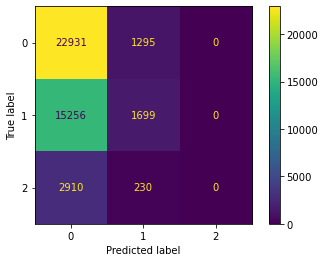

In [35]:
plot_confusion_matrix(logreg, x, y)

In [36]:
# # Not a great model to begin with
# # Let's try a Decision Tree Classifier

# from sklearn.tree import DecisionTreeClassifier

# dt = DecisionTreeClassifier()
# dt.fit(x,y)



In [37]:
# cross_val_score(dt, x, y=y)

In [38]:
# from sklearn.neighbors import KNeighborsClassifier

# knn = KNeighborsClassifier()
# knn.fit(x,y)
# knn.score(x,y)

In [ ]:
# cat_features = [
#     'region', 'scheme_management', 'extraction_type', 'management',
#     'water_quality', 'source', 'status_group'
# ]

# train_cat_2 = train_cat[cat_features]

# ohe = OneHotEncoder(categories = 'auto', sparse = False, drop='first')
# test_data_2 = ohe.fit_transform(train_cat_2.drop('status_group', axis=1))
# test_data_df = pd.DataFrame(test_data_2, columns=ohe.get_feature_names())
# test_data_df

# test_data_target = test_data_df.join(train_cat['status_group'])
# test_data_target = test_data_target.join(train_num_scaled_final)
# test_data_target
# status_group_dict = {'functional' : 0, 'non functional' : 1, 'functional needs repair' : 2}
# test_data_target['status_group'].replace(status_group_dict, inplace=True)
# test_data_target

# final_test_set = test_data_target.join(train_num_scaled_final)
# final_test_set.dropna(inplace=True)
# final_test_set

In [ ]:
weight_dict = {0 : 0.55, 1 : 0.38, 2 : 0.07 }

In [ ]:
logreg = LogisticRegression(solver='saga', class_weight=weight_dict)
x = final_test_set.drop('status_group', axis=1)
y = final_test_set['status_group']

logreg.fit(x,y)

logreg.score(x,y)

In [ ]:
plot_confusion_matrix(logreg, x, y)

In [ ]:
# Not a great model to begin with
# Let's try a Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(x,y)
print(dt.score(x,y))

(cross_val_score(dt, x, y))

In [ ]:
plot_confusion_matrix(dt, x, y)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x,y)
knn.score(x,y)

In [ ]:
plot_confusion_matrix(knn, x, y)

In [ ]:
(cross_val_score(knn, x, y))

In [ ]:
# parameters_log = {'penalty' : ('l1', 'l2’)}
                               
# , 'class_weight' : ('balanced', 'none'), 
#                  'solver' : ('sag', 'saga')}                               

In [ ]:
parameters_log = {'penalty' : ('l1', 'l2'), 'class_weight' : ('balanced', 'none'), 
                 'solver' : ('sag', 'saga')}

clf = GridSearchCV(logreg, parameters_log)
clf.fit(x,y)
clf.best_params_

In [ ]:
y.value_counts()

In [ ]:
3140/(24226+16955+3140)

In [ ]:
sm = SMOTE()

In [ ]:
x_res, y_res = sm.fit_resample(x, y)

In [ ]:
len(x_res)

In [ ]:
logreg.score(x_res, y_res)

In [ ]:
## Trying a model using only numerical data and less categorical data.


from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score


def model_score(y_hat, y):
    acc = accuracy_score(y, y_hat)
    rec = recall_score(y, y_hat)
    f1 = f1_score(y, y_hat)
    precision_score(y, y_hat)
    
    print(f' The accuracy score is: {acc}')

